In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.optim import Adam

from tqdm import tqdm
from numpy.lib.stride_tricks import sliding_window_view

## 1.  Data

In [2]:
def f(x, noise = True, sigma_eps = 0.1):
    y = math.sin(x)
    if noise:
        y += sigma_eps*np.random.randn(1)
    return y

In [3]:
sigma_eps = 0.3
xs = np.linspace(-4,4,200)
ys = np.array([f(x = x, noise = True, sigma_eps = sigma_eps) for x in xs])

Choose 10 datapoints for training

In [4]:
np.random.seed(100)
train_idx = np.random.randint(0, len(xs), 100)
#train_idx = np.append(train_idx, np.random.randint(150, 170, 30))
xs_train = torch.tensor(xs[train_idx]).unsqueeze(-1).float()
ys_train = torch.tensor(ys[train_idx]).float()

Text(0, 0.5, 'y')

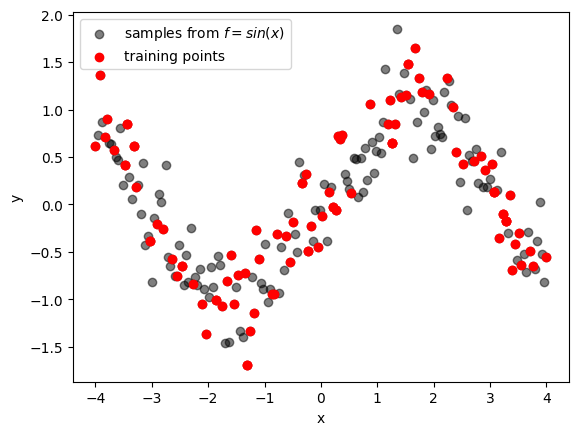

In [5]:
plt.scatter(xs, ys, c = 'black', label = 'samples from $f = sin(x)$', alpha =.5)
plt.scatter(xs_train, ys_train, c = 'red', label = 'training points', alpha = 1)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

## Model

In [6]:
data = TensorDataset(xs_train, ys_train)
train_set, val_set = torch.utils.data.random_split(data, [80, 20])
dataloader_train = DataLoader(train_set, shuffle = True, batch_size=5)
dataloader_val = DataLoader(val_set, shuffle = True, batch_size=20)

In [7]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 100), nn.Linear(100, 100), nn.ReLU(),
                                nn.Linear(100, 5))
        self.last_layer = nn.Linear(5, 1)
    
    def forward(self, x):
        x = self.fc(x)
        x = self.last_layer(x)
        return x
    
    def get_ll_embedd(self, x):
        x = self.fc(x)
        return x

In [8]:
num_epochs = 1000

torch.manual_seed(758)
torch.use_deterministic_algorithms(True)
model = SimpleNet()
wd = 1e-5
sigma_0 = 1/wd
optimizer = Adam(lr = 1e-3, params = model.parameters(), weight_decay=wd)

loss_fn = nn.MSELoss()

losses_train = []
losses_val = []
for _ in tqdm(range(num_epochs)):
    # Training step
    loss_train = 0
    for x, y in dataloader_train:
        optimizer.zero_grad()
        
        y_pred = model.forward(x)
        
        loss = loss_fn(y, y_pred)  
        loss.backward()

        optimizer.step()

        loss_train += loss.item() * x.size(0)
    
    losses_train.append(loss_train/ len(dataloader_train.dataset))
    
    
    # Validation step
    val_loss = 0
    for x_val, y_val in dataloader_val:
        
        with torch.no_grad():
            y_pred_val = model.forward(x_val)
            loss = loss_fn(y_val, y_pred_val)  
            val_loss += loss.item() * x_val.size(0)
    
    losses_val.append(val_loss / len(dataloader_val.dataset))

            

100%|██████████| 1000/1000 [00:05<00:00, 181.75it/s]


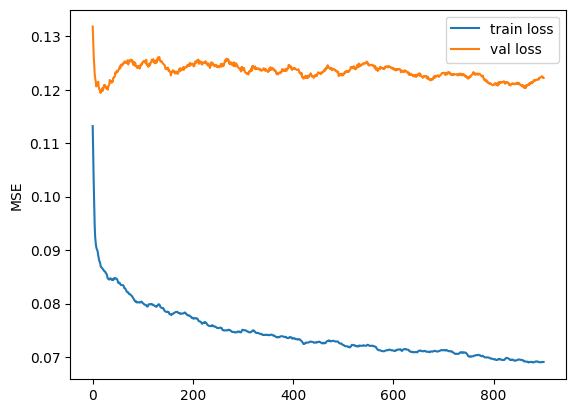

In [9]:
plt.plot(sliding_window_view(np.array(losses_train), 100).mean(axis=1), label = 'train loss')
plt.plot(sliding_window_view(np.array(losses_val), 100).mean(axis=1), label = 'val loss')
plt.ylabel('MSE')
plt.legend()

# Last-layer Posterior

In [10]:
model.eval()
xs_pred_np = np.linspace(-10,10,200)
xs_pred = torch.tensor(xs_pred_np).float().unsqueeze(-1)
ys_pred = model.forward(xs_pred)

Psi = model.get_ll_embedd(xs_train)

# get posterior mean and covariance
d = Psi.shape[1]
Sigma_N_inv = (1/sigma_0**2)*torch.eye(d) + (1/sigma_eps**2)*(Psi.T @ Psi)
Sigma_N = torch.linalg.inv(Sigma_N_inv)
mu_N = Sigma_N @ ((1/sigma_eps**2)*(Psi.T @ ys_train))

def get_post_pred_dens(x_star, mu_N, Sigma_N, sigma_eps):
    psi_star = model.get_ll_embedd(torch.tensor(x_star).reshape(1,1).float())
    mu_star = mu_N.T @ psi_star.T
    sigma_sq_star = sigma_eps**2 + psi_star @ Sigma_N @ psi_star.T
    return mu_star.detach().item(), sigma_sq_star.detach().item()

In [11]:
pred_mu_sigma = [get_post_pred_dens(x, mu_N, Sigma_N, sigma_eps) for x in xs_pred_np]
pred_mus = np.array([pred_mu_sigma[i][0] for i in range(len(pred_mu_sigma))])
pred_sigmas = np.array([pred_mu_sigma[i][1]for i in range(len(pred_mu_sigma))])

In [12]:
Psi_pred = model.get_ll_embedd(xs_pred.unsqueeze(-1).float())
# sample weights from posterior
L = torch.linalg.cholesky(Sigma_N) 
num_samples = 10
w_samples = mu_N.repeat(1, num_samples) + L @ torch.randn(5, num_samples)
pred_samples = [Psi_pred @ w for w in w_samples.T]

In [13]:
(L @ torch.randn(5, num_samples)).shape

torch.Size([5, 10])

# Inference

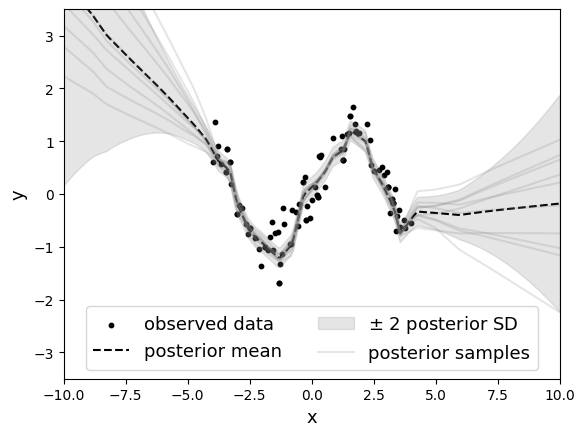

In [30]:
TEXT_SIZE = 13
ys_no_noise = np.array([f(x = x, noise = False, sigma_eps = sigma_eps) for x in xs])

fig, axs = plt.subplots(1,1)
axs.scatter(xs_train, ys_train, c = 'black', label = 'observed data', alpha = 1, s = 10)
axs.plot(xs_pred_np, pred_mus, c = 'black', linestyle = 'dashed', label = 'posterior mean')
axs.fill_between(xs_pred_np, pred_mus - 2*pred_sigmas,  pred_mus + 2*pred_sigmas, color = 'grey', label = r'$\pm$ 2 posterior SD', alpha = 0.2)

for i, sample in enumerate(pred_samples):
    if i < num_samples - 1:
        axs.plot(xs_pred_np, sample.detach().numpy(), color = 'gray', alpha = 0.2)
    else:
        axs.plot(xs_pred_np, sample.detach().numpy(), color = 'gray', alpha = 0.2, label = 'posterior samples')


axs.legend(ncols = 2, loc='lower center', fontsize = TEXT_SIZE)
axs.set_xlabel('x', size = TEXT_SIZE)
axs.set_ylabel('y', size = TEXT_SIZE)
#axs.set_xticks([], [])
#axs.set_yticks([], [])

axs.set_xlim(-10,10)
axs.set_ylim(-3.5, 3.5)

fig.savefig('1d_regression.pdf')